# Ejemplo de identificación, estimación, diagnóstico y pronósticos de un modelo ARIMA

## Librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF
from pmdarima import auto_arima
from pmdarima import ARIMA
from PythonTsa.ModResidDiag import plot_ResidDiag
from scipy.stats import shapiro, jarque_bera

## Lectura de datos

Los datos corresponde al PIB de Colombia observado trimestralmente y desestacionalizado, desde el primer trimestre del año 2000 al cuarto trimestre del año 2015

In [3]:
z = pd.read_csv('../Data/PIB_real_2000_1_2015_4.txt', header=None, names=["x"])

In [4]:
len(z)

64

La serie es corta, esto puede dificultar la identiciación del proceso

In [5]:
# Agregamos columna de fechas
num_trimestres = len(z)

fechas_trimestrales = pd.date_range(start='2000-01-01', periods=num_trimestres, freq='QE')
z.index = fechas_trimestrales

print(z.head())
print()
print(z.tail())

                  x
2000-03-31  70991.0
2000-06-30  71017.0
2000-09-30  71421.0
2000-12-31  71332.0
2001-03-31  71846.0

                   x
2014-12-31  130168.0
2015-03-31  131171.0
2015-06-30  132204.0
2015-09-30  133601.0
2015-12-31  134400.0


## Etapa de Identificación

### **Análisis de estabilidad de varianza**

Es necesario usar la transformación de Box-Cox?

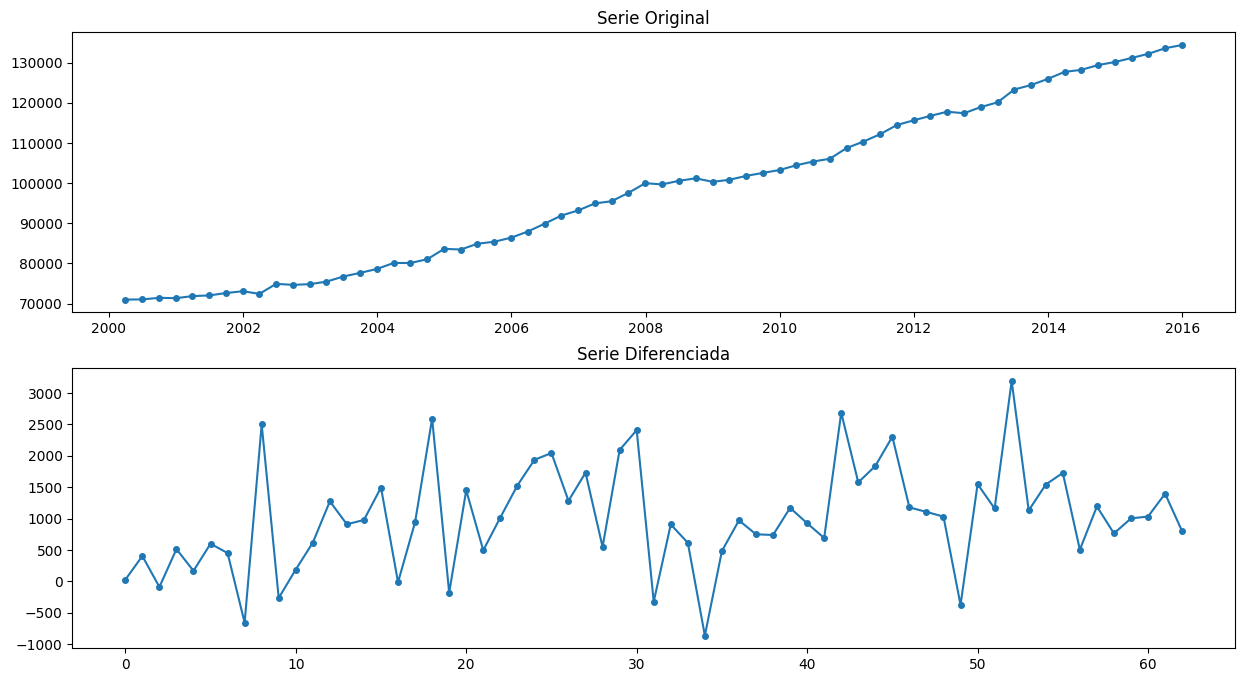

In [6]:

fig, axs = plt.subplots(2, figsize=(15,8))

axs[0].plot(z['x'], marker='o', markersize=4)
axs[0].set_title('Serie Original')

axs[1].plot(np.diff(z['x']), marker='o', markersize=4)
axs[1].set_title('Serie Diferenciada')

plt.show()

In [7]:
z_transformed, lambda_param = stats.boxcox(z['x'])
print("Parámetro lambda: ", lambda_param)

Parámetro lambda:  0.005020135456892655


Box-Cox sugieren una transformación logarítmica, ya que el parámetro lambda se aproxima a cero. 



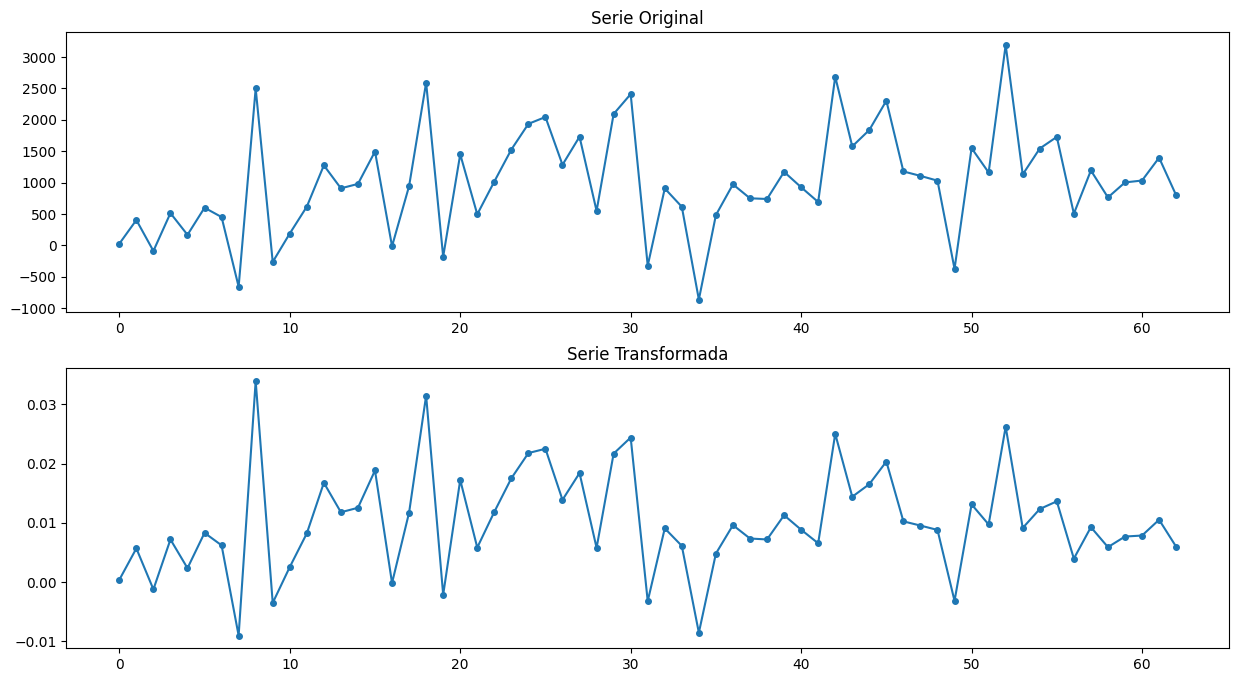

In [8]:
# Compraración de las primeras diferencias de la serie original y transformada:

fig, axs = plt.subplots(2, figsize=(15,8))

axs[0].plot(np.diff(z['x']), marker='o', markersize=4)
axs[0].set_title('Serie Original')

axs[1].plot(np.diff(np.log(z['x'])), marker='o', markersize=4)
axs[1].set_title('Serie Transformada')

plt.show()

Se observa que la transformación logarítmica no parece tener efecto.

**Conclusión:** se propone usar la transformación lambda=1, es decir, no transofrmar la serie y seguir trabajando con la serie original z

### Determinación del valor de d

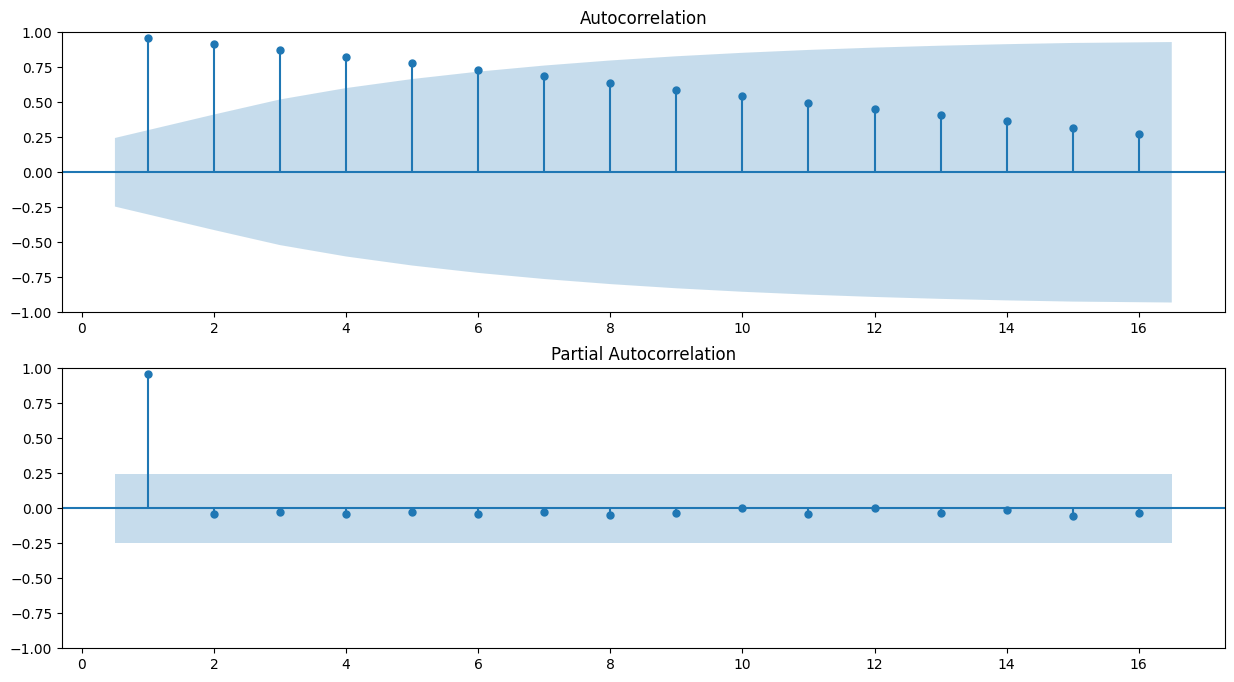

In [9]:
### Correlogramas muestrales de la serie original

# Cálcula el rezago máximo
max_rezag = round(len(z) / 4)

fig, axs = plt.subplots(2, figsize=(15,8))

# ACF
sm.graphics.tsa.plot_acf(z['x'], ax=axs[0], lags=max_rezag, alpha=0.05, zero=False)
# PACF
sm.graphics.tsa.plot_pacf(z['x'], ax=axs[1], lags=max_rezag, alpha=0.05, zero=False)

plt.show()

Del gráfico de z y sus correlogramas, se concluye que la serie es no estacionaria. Que tipo de serie es, TS o DS?

### Prueba de raíces unitarias


#### Usando [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [10]:
maxlag = int(np.floor(12 * (len(z) / 100) ** (1/4)))
maxlag

10

In [11]:
# Usando el criterio AIC
ru_z = adfuller(z['x'], maxlag=maxlag, regression='ct', autolag='AIC', store=True, regresults=True)

In [12]:
print("Augmented Dickey-Fuller Test Unit Root Test")
print("ADF Statistics: ", ru_z[0])
print("p-value: ", ru_z[1])
print("Critical Values: ")
for key, value in ru_z[2].items():
    print(f"\t{key}: {value}")

Augmented Dickey-Fuller Test Unit Root Test
ADF Statistics:  -2.8173048814732398
p-value:  0.19066116936261696
Critical Values: 
	1%: -4.118172754629629
	5%: -3.486383398148148
	10%: -3.1713372222222223


Los resultados de la prueba de Dickey-Fuller Aumentada (ADF) se utilizan para determinar si una serie temporal es estacionaria. La prueba ADF tiene como hipótesis nula que una unidad de raíz está presente en una serie de tiempo (es decir, que la serie es no estacionaria).

* **ADF Statistic:** Es el valor del estadístico de la prueba ADF. Un valor más negativo indica una evidencia más fuerte contra la hipótesis nula.

* **p-value:** Es el valor p asociado con el estadístico de la prueba. Un valor p pequeño (generalmente menor a 0.05) rechaza la hipótesis nula, lo que indica que la serie es estacionaria.

* **Critical Values:** Son los valores críticos a diferentes niveles de significancia. Si el estadístico ADF es menor (más negativo) que el valor crítico, entonces se rechaza la hipótesis nula.

En este caso, el valor ADF es -2.81 y el valor p es 0.19. Como el valor p es mayor que 0.05, no se puede rechazar la hipótesis nula. Esto significa que hay evidencia fuerte para sugerir que la serie de tiempo no es estacionaria.

Además, el valor ADF es mayor que los valores críticos a los niveles de significancia del 1%, 5% y 10%. Esto refuerza la conclusión de que no se puede rechazar la hipótesis nula y por tanto, la serie se considera no estacionaria.

In [13]:
# Usando el criterio BIC
ru_z = adfuller(z['x'], maxlag=maxlag, regression='ct', autolag='BIC', store=True, regresults=True)
print("Augmented Dickey-Fuller Test Unit Root Test")
print("ADF Statistics: ", ru_z[0])
print("p-value: ", ru_z[1])
print("Critical Values: ")
for key, value in ru_z[2].items():
    print(f"\t{key}: {value}")

Augmented Dickey-Fuller Test Unit Root Test
ADF Statistics:  -2.9373912505039814
p-value:  0.1504341334363124
Critical Values: 
	1%: -4.110169028582626
	5%: -3.482636994764984
	10%: -3.1691696870988255


#### Usando la librería [arch](https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ADF.html)

In [14]:
# Usando el criterio AIC
ru_z = ADF(y=z['x'], lags=maxlag, trend='ct', method='AIC')

In [15]:
print(ru_z.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.589
P-value                         0.285
Lags                               10
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.14 (1%), -3.50 (5%), -3.18 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [16]:
# Usando el criterio BIC
ru_z = ADF(y=z['x'], lags=maxlag, trend='ct', method='BIC')
print(ru_z)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.589
P-value                         0.285
Lags                               10
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.14 (1%), -3.50 (5%), -3.18 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Validación de la ecuación ADF

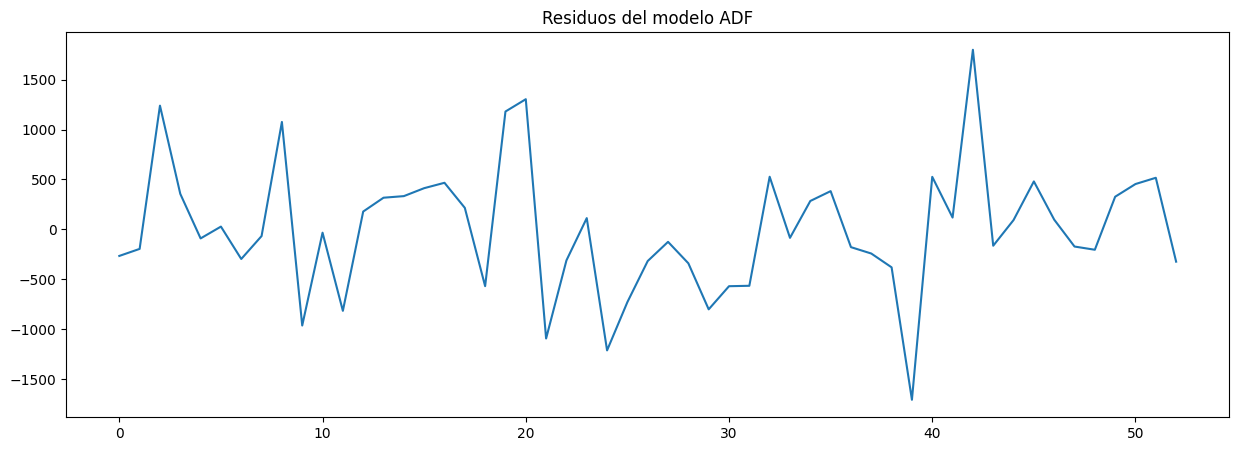

In [17]:
res = ru_z.regression.resid

plt.figure(figsize=(15,5))
plt.plot(res)
plt.title("Residuos del modelo ADF")
plt.show()

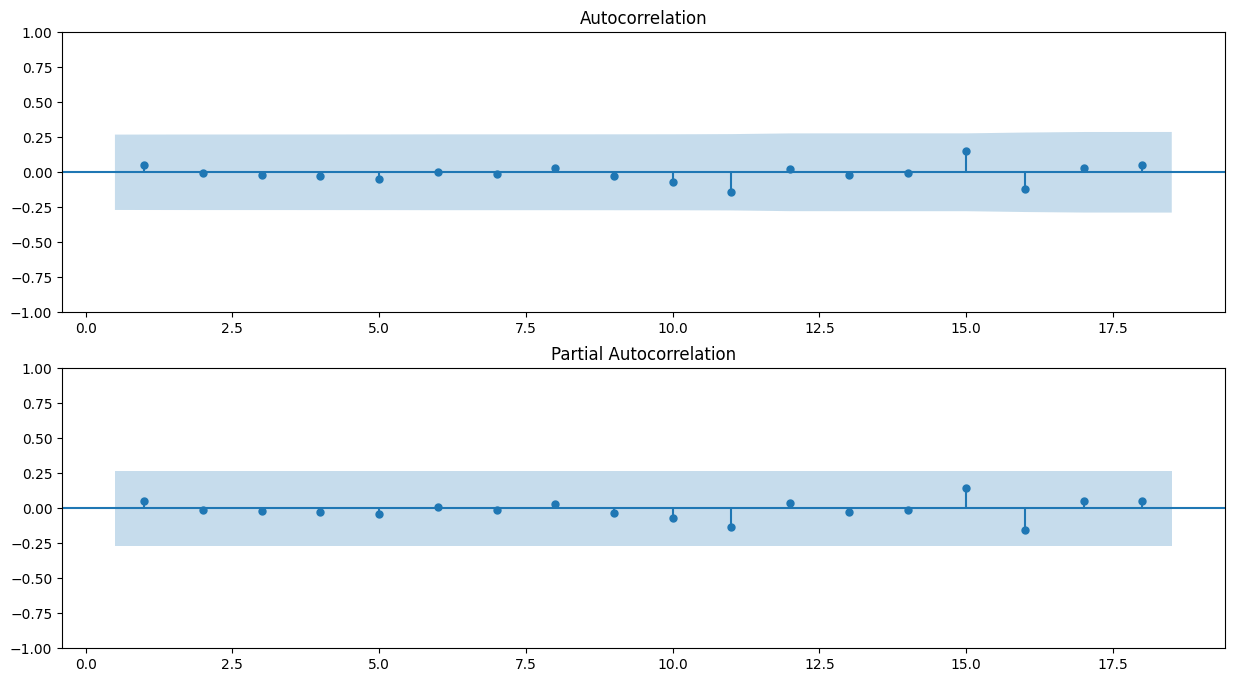

In [18]:
# Correlogramas de los residuales

fig, axs = plt.subplots(2, figsize=(15,8))

# ACF
sm.graphics.tsa.plot_acf(res, ax=axs[0],  alpha=0.05, zero=False)
# PACF
sm.graphics.tsa.plot_pacf(res, ax=axs[1],  alpha=0.05, zero=False)

plt.show()

In [19]:
# Busquemos el mejor modelo ARIMA para los residuales

model = auto_arima(res, max_p=5, max_q=5, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=837.479, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=839.341, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=839.332, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=841.332, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=839.479, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.121 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                        SARIMAX   Log Likelihood                -417.740
Date:                Sat, 04 May 2024   AIC                            837.479
Time:                        16:04:50   BIC                            839.449
Sample:                             0   HQIC                           838.237
                    

In [20]:
# Ajustemos un modelo ARIMA(0,0,0) a los residuales

model = ARIMA(order=(0,0,0))
model_fit = model.fit(y=res)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                        SARIMAX   Log Likelihood                -417.740
Date:                Sat, 04 May 2024   AIC                            839.479
Time:                        16:04:50   BIC                            843.420
Sample:                             0   HQIC                           840.995
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    9.14e-11     88.611   1.03e-12      1.000    -173.674     173.674
sigma2      4.108e+05   6.79e+04      6.052      0.000    2.78e+05    5.44e+05
Ljung-Box (L1) (Q):                   0.16   Jarque-

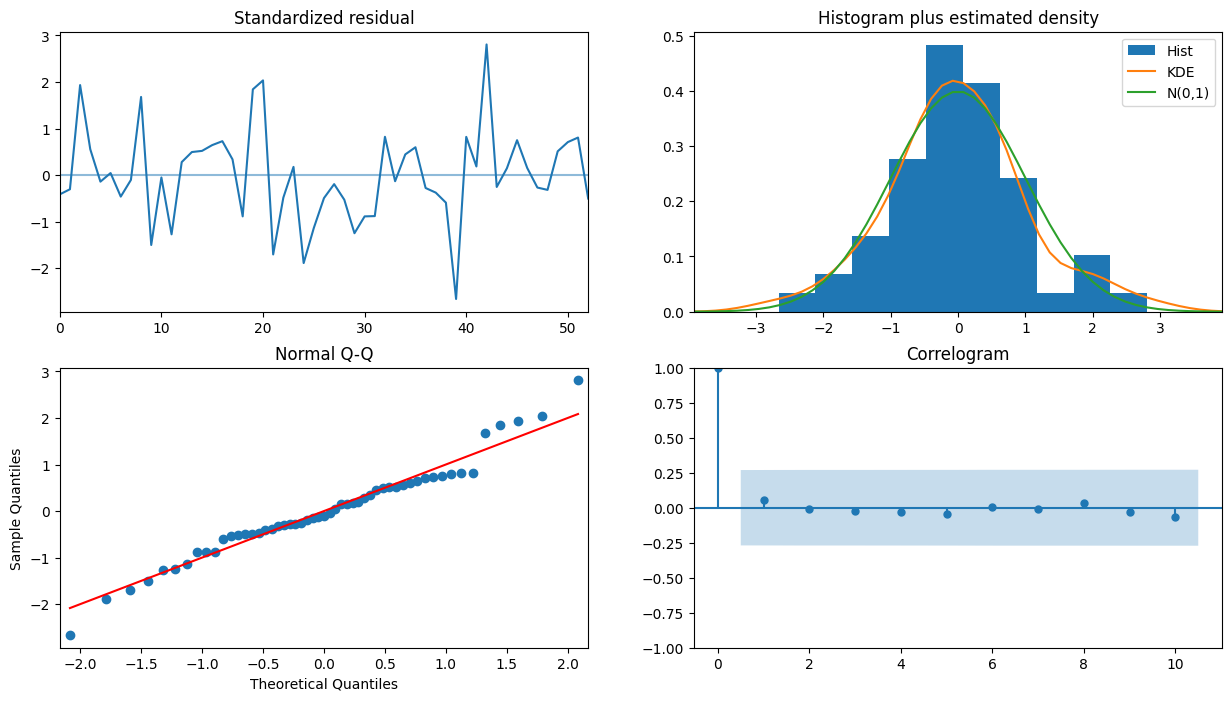

In [21]:
# Diagnostico del modelo ARIMA(0,0,0)
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

Pruebas de Normalidad

In [22]:
# Prueba de Shapiro-Wils
stat, p = shapiro(res)
print("Estadístico de Shapiro-Wilks: %.3f, p-value: %.3f" % (stat, p))

# Prueba Jarque-Bera
stat, p = jarque_bera(res)
print("Estadístico de Jarque-Bera: %.3f, p-value: %.3f" % (stat, p))

Estadístico de Shapiro-Wilks: 0.975, p-value: 0.335
Estadístico de Jarque-Bera: 1.731, p-value: 0.421


**1. Prueba de Shapiro-Wilks:** Esta prueba evalúa la hipótesis nula de que los datos provienen de una distribución normal. En este caso, el estadístico de Shapiro-Wilks es 0.998 y el valor p es 0.335. Dado que el valor p es mayor que 0.05, no se puede rechazar la hipótesis nula de que los residuos se distribuyen normalmente.

**2. Prueba de Jarque-Bera:** Esta prueba es una prueba de bondad de ajuste que evalúa si los datos tienen la asimetría y la curtosis de una distribución normal. Al igual que con la prueba de Shapiro-Wilks, no se puede rechazar la hipótesis nula de que los datos se distribuyen normalmente porque el valor p (0.421) es mayor que 0.05.

El modelo ADF satisface los supuestos básicos.

**Conclusión:** la serie Z contiene al menos una raíz unitaria

#### Examen de más raícies unitarias

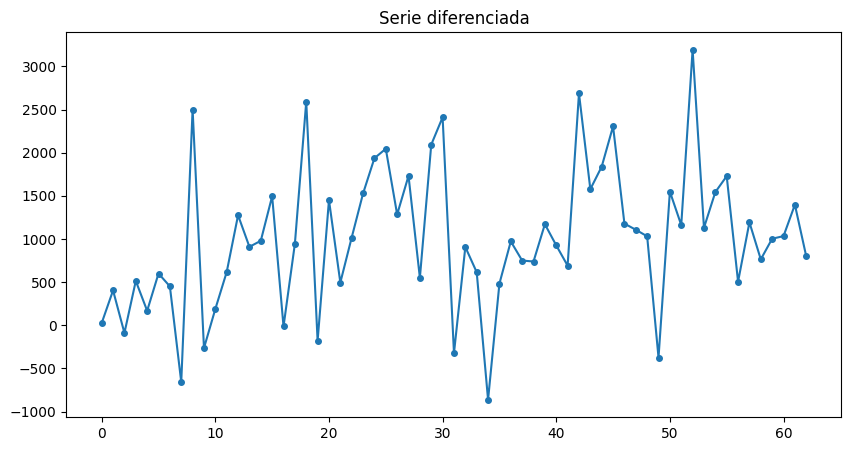

In [23]:
# Gráfico de la serie diferenciada una vez

plt.figure(figsize=(10,5))
plt.plot(np.diff(z['x']), marker='o', markersize=4)
plt.title("Serie diferenciada")
plt.show()


In [24]:
# Prueba de si hay raíz unitaria en z diferenciada una vez
ru_z = ADF(y=np.diff(z['x']), lags=maxlag, trend='c', method='AIC')
print(ru_z)

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.065
P-value                         0.029
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [25]:
# Usando el criterio BIC
ru_z = adfuller(np.diff(z['x']), maxlag=maxlag, regression='c', autolag='AIC', store=True, regresults=True)
print("Augmented Dickey-Fuller Test Unit Root Test")
print("ADF Statistics: ", ru_z[0])
print("p-value: ", ru_z[1])
print("Critical Values: ")
for key, value in ru_z[2].items():
    print(f"\t{key}: {value}")

Augmented Dickey-Fuller Test Unit Root Test
ADF Statistics:  -7.461902185381903
p-value:  5.326694930571412e-11
Critical Values: 
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696


**Conclusión:** la serie Z diferenciada no contiene raíz unitaria. Por lo tanto, la serie Z pertenece a la clase de modelos ARIMA con deriva y d=1

### Determinación de los valores de (p, q) del modelo ARMA para Wt = (1-B)Zt

#### Correlogramas muestrales para Z diferenciada una vez

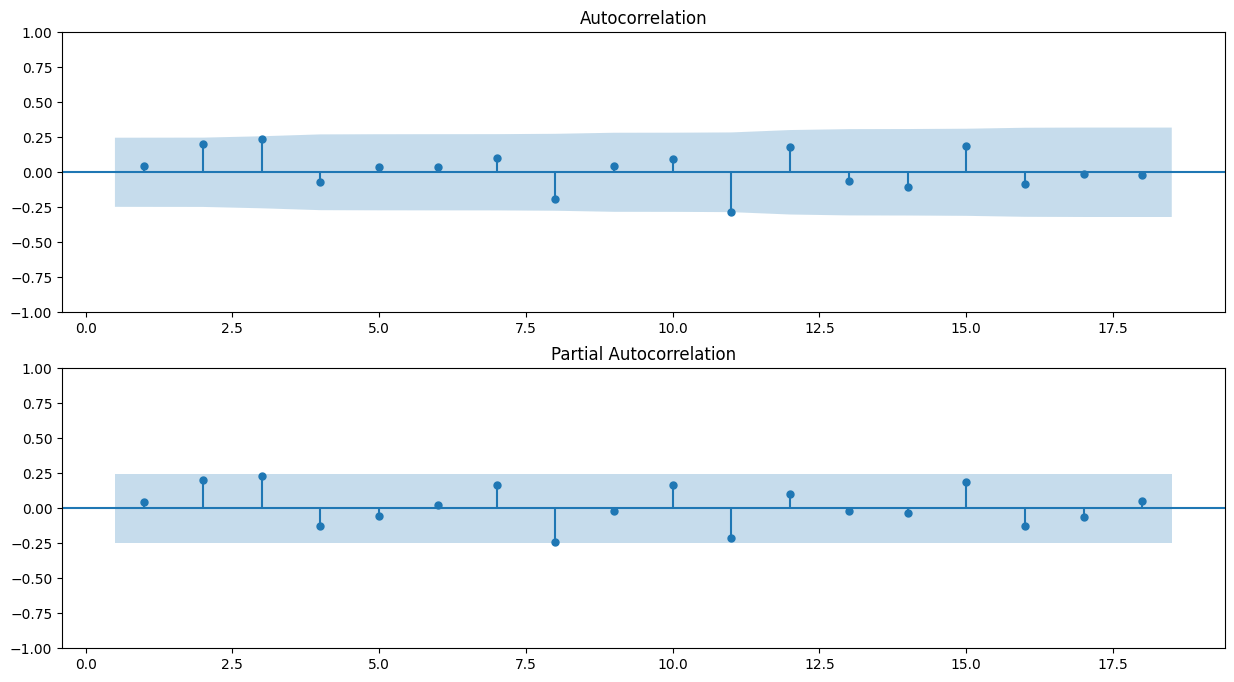

In [26]:
# Correlogramas muestrales para z diferenciada una vez

fig, axs = plt.subplots(2, figsize=(15,8))

# ACF
sm.graphics.tsa.plot_acf(np.diff(z['x']), ax=axs[0],  alpha=0.05, zero=False)
# PACF
sm.graphics.tsa.plot_pacf(np.diff(z['x']), ax=axs[1],  alpha=0.05, zero=False)

plt.show()

Parece que el proceso que genera la serie Z es un ARIMA(0,1,0).